In [1]:
import os
import time
import sys
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score # For IoU
from tqdm import tqdm
import wandb

config_path = '/home/stud/fmarchetto/SegmentationTests/Project/'  
sys.path.append(config_path)
from config import Config
wandb.login()



wandb: Currently logged in as: marchettofrancesco (marchetto_francesco) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
config_path = '/home/stud/fmarchetto/SegmentationTests/Project/'  
sys.path.append(config_path)
from config import Config
try:
    from config import Config as cfg  
    print("Config imported successfully as 'cfg'.")
except ImportError as e:
    print(f"Import failed: {e}. Check if config.py exists in {config_path} and paths match.")
cfg

Config imported successfully as 'cfg'.


{'base_dir': '/home/stud/fmarchetto/SegmentationTests/Data/',
 'datasets': {'balanced': '/home/stud/fmarchetto/SegmentationTests/Data/balanced_train_df.csv'},
 'val_csv': '/home/stud/fmarchetto/SegmentationTests/Data/val_df.csv',
 'test_csv': '/home/stud/fmarchetto/SegmentationTests/Data/test_df.csv',
 'models': [{'name': 'U-Net ResNet34', 'arch': 'Unet', 'encoder': 'resnet34'},
  {'name': 'DeepLabV3+ ResNet50',
   'arch': 'DeepLabV3Plus',
   'encoder': 'resnet50'}],
 'batch_sizes': [50],
 'learning_rates': [0.001, 0.0001],
 'optimizers': [{'name': 'RMSprop',
   'class': 'RMSprop',
   'extra_params': {'momentum': 0.9}},
  {'name': 'Adam', 'class': 'Adam'}],
 'epochs': 8,
 'patience_early_stop': 3,
 'device': "torch.device('cuda' if torch.cuda.is_available() else 'cpu')",
 'wandb_project': 'Zuliani1_Marchetto2',
 'transform': 'A.Compose([\n    A.HorizontalFlip(p=0.5),\n    A.Normalize(mean=0.5, std=0.25),\n    ToTensorV2()\n])'}

In [12]:
!pwd
!ls -l /home/stud/fmarchetto/SegmentationTests/Data/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46.tif
!ls -l /home/stud/fmarchetto/SegmentationTests/Data/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif

/home/stud/fmarchetto/SegmentationTests/Project
ls: cannot access '/home/stud/fmarchetto/SegmentationTests/Data/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46.tif': No such file or directory
-rw-r--r-- 1 fmarchetto stud 65746 Oct 31 10:45 /home/stud/fmarchetto/SegmentationTests/Data/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_9_mask.tif


In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR


Next is the code we used to train all the combinations of 2 models, 'U-Net ResNet34'and 'DeepLabV3+ ResNet50', with 2 different learning rates, we used 4 optimizers even if they may not be in the current code, we started with SGD and ADAM, then used SGD with momentum and RMSprop, 2 different batch sizes 8,16 and then stick with 8 since it was performing better

In [4]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'])
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            print(f"Warning: Skipping invalid file - Image: {row['image_path']}, Mask: {row['mask_path']}")
            next_idx = (idx + 1) % len(self)
            if next_idx == idx:
                raise ValueError("All files in dataset are invalid!")
            return self.__getitem__(next_idx)
        
        # UPDATED: Per image normalization (compute mean/std for this image)
        mean = np.mean(img)
        std = np.std(img) + 1e-6  # Avoid division by zero
        normalize = A.Normalize(mean=mean, std=std)
        augmented = normalize(image=img, mask=mask)
        
        # Apply the rest of the transforms
        if self.transform:
            augmented = self.transform(**augmented)
        
        return augmented['image'], augmented['mask'] / 255.0  # Normalize mask to [0,1]

# Loss and Metrics (UPDATED: Focal + Dice loss) 
def focal_dice_loss(pred, target, gamma=2.0, alpha=0.25):
    """
    pred: raw logits [B, 1, H, W]
    target: ground truth [B, 1, H, W]
    """
    # Focal BCE component
    bce_loss = nn.functional.binary_cross_entropy_with_logits(
        pred, target, reduction='none'
    )
    pred_prob = torch.sigmoid(pred)  # Convert logits to probabilities
    pt = torch.where(target == 1, pred_prob, 1 - pred_prob)  # Probability of true class
    focal = alpha * (1 - pt) ** gamma * bce_loss
    
    # Dice component
    pred_prob = torch.sigmoid(pred)  # Already computed above, but kept for clarity
    intersection = (pred_prob * target).sum()
    dice_loss = 1 - (2 * intersection + 1e-6) / (pred_prob.sum() + target.sum() + 1e-6)
    
    return focal.mean() + dice_loss

def compute_dice(pred, target, threshold=0.5):
    pred_prob = torch.sigmoid(pred)  # ← ADD THIS
    pred_bin = (pred_prob > threshold).float()
    intersection = (pred_bin * target).sum()
    return (2 * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)

def compute_iou(pred, target, threshold=0.5, zero_division=0):
    pred_prob = torch.sigmoid(pred)  # ← ADD THIS
    pred_bin = (pred_prob > threshold).float().cpu().numpy().flatten()
    target = target.cpu().numpy().flatten()
    return jaccard_score(target, pred_bin, average='binary', zero_division=zero_division)

def compute_class_iou(pred, target, threshold=0.5, class_id=1):
    pred_prob = torch.sigmoid(pred)  # ← ADD THIS
    pred_bin = (pred_prob > threshold).float().cpu().numpy().flatten()
    target = (target == class_id).float().cpu().numpy().flatten()
    return jaccard_score(target, pred_bin, average='binary', zero_division=0)

# --- Early Stopping Class (unchanged) ---
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_model(dataset_type, batch_size, lr, optimizer_name, model_info):
    # Load datasets
    train_csv = cfg['datasets'][dataset_type]
    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(cfg['val_csv'])
    
    # Use eval to get the transform and device
    transform = eval(cfg['transform'])
    device = eval(cfg['device'])
    
    train_dataset = MriDataset(train_df, transform)
    val_dataset = MriDataset(val_df, transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model setup
    model = getattr(smp, model_info['arch'])(encoder_name=model_info['encoder'], classes=1, activation=None).to(device)
    
    # UPDATED: Optimizer with extra params from config
    opt_config = next(opt for opt in cfg['optimizers'] if opt['name'] == optimizer_name)
    optimizer_class = getattr(torch.optim, opt_config['class'])
    extra_params = opt_config.get('extra_params', {})
    optimizer = optimizer_class(model.parameters(), lr=lr, **extra_params)
    
    # UPDATED: ReduceLROnPlateau + Warmup scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.7)  # More aggressive
    warmup_epochs = 3
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: min((epoch + 1) / warmup_epochs, 1.0))
    
    run_name = f"{model_info['name']}_{optimizer_name}_LR{lr}_Batch{batch_size}_{dataset_type}"
    run = wandb.init(
        project=cfg['wandb_project'],
        name=run_name,
        config={
            'dataset_type': dataset_type,
            'batch_size': batch_size,
            'lr': lr,
            'optimizer': optimizer_name,
            'model': model_info['name'],
            'epochs': cfg['epochs']
        }
    )
    
    early_stopping = EarlyStopping(patience=cfg['patience_early_stop'])
    best_model_path = f"best_model_{dataset_type}_{model_info['name']}.pth"
    
    for epoch in range(cfg['epochs']):
        model.train()
        train_loss = 0
        train_dice = 0
        train_iou = 0
        train_acc = 0
        train_iou_tumor = 0  # UPDATED: Class-wise IoU for tumor
        num_batches = len(train_loader)
        
        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} - Train"):
            img, mask = img.to(device), mask.to(device).unsqueeze(1)
            optimizer.zero_grad()
            pred = model(img)
            loss = focal_dice_loss(pred, mask)  # UPDATED: Use new loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            train_dice += compute_dice(pred, mask).item()
            train_iou += compute_iou(pred, mask)
            train_iou_tumor += compute_class_iou(pred, mask, class_id=1)  # UPDATED: Tumor IoU
            pred_prob = torch.sigmoid(pred)  # ← ADD THIS
            pred_bin = (pred_prob > 0.5).float()
            train_acc += (pred_bin == mask).float().mean().item()
        
        train_loss /= num_batches
        train_dice /= num_batches
        train_iou /= num_batches
        train_iou_tumor /= num_batches
        train_acc /= num_batches
        
        # Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        val_acc = 0
        val_iou_tumor = 0  # UPDATED: Class-wise IoU for tumor
        num_val_batches = len(val_loader)
        
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg['epochs']} - Val"):
                img, mask = img.to(device), mask.to(device).unsqueeze(1)
                pred = model(img)
                val_loss += focal_dice_loss(pred, mask).item()  # UPDATED: Use new loss
                val_dice += compute_dice(pred, mask).item()
                val_iou += compute_iou(pred, mask)
                val_iou_tumor += compute_class_iou(pred, mask, class_id=1)  # UPDATED
                pred_prob = torch.sigmoid(pred)  # ← ADD THIS
                pred_bin = (pred_prob > 0.5).float()
                val_acc += (pred_bin == mask).float().mean().item()
        
        val_loss /= num_val_batches
        val_dice /= num_val_batches
        val_iou /= num_val_batches
        val_iou_tumor /= num_val_batches
        val_acc /= num_val_batches
        
        # UPDATED: Step schedulers (warmup first, then plateau)
        if epoch < warmup_epochs:
            warmup_scheduler.step()
        scheduler.step(val_loss)
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        
        # Log to WandB (UPDATED: Added class-wise IoU)
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_dice': train_dice,
            'val_dice': val_dice,
            'train_iou': train_iou,
            'val_iou': val_iou,
            'train_acc': train_acc,
            'val_acc': val_acc
        })
    
    # Save best model
    torch.save(model.state_dict(), best_model_path)
    wandb.save(best_model_path)
    
    run.finish()  # End wandb run

# --- Run the Grid Search Over All Combinations (unchanged) ---
for dataset_type in cfg['datasets'].keys():
    for batch_size in cfg['batch_sizes']:
        for lr in cfg['learning_rates']:
            for opt in cfg['optimizers']:
                for model_info in cfg['models']:
                    print(f"\nStarting run: Dataset={dataset_type}, Batch={batch_size}, LR={lr}, Opt={opt['name']}, Model={model_info['name']}")
                    train_model(dataset_type, batch_size, lr, opt['name'], model_info)


Starting run: Dataset=balanced, Batch=50, LR=0.001, Opt=RMSprop, Model=U-Net ResNet34


Epoch 8/8 - Val: 100%|██████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


Early stopping triggered.


epoch,▁▂▃▅▆▇█
train_acc,█▁▁▁▁▂▃
train_dice,▁▆▇████
train_iou,▁▆▇████
train_loss,█▆▄▂▂▂▁
val_acc,███▁▅██
val_dice,▁▁▁▅█▁▁
val_iou,▁▁▁▅█▁▁
val_loss,█▅▇▂▁▃▅
epoch,7
train_acc,0.93771



Starting run: Dataset=balanced, Batch=50, LR=0.001, Opt=RMSprop, Model=DeepLabV3+ ResNet50


Epoch 8/8 - Val: 100%|██████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


epoch,▁▂▃▄▅▆▇█
train_acc,▁▆▆▇▆▆██
train_dice,▁▇▇█████
train_iou,▁▇▇█▇███
train_loss,█▃▃▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁
val_dice,▁▁▁▁▁▁▁▁
val_iou,▁▁▁▁▁▁▁▁
val_loss,█▇▁▄█▁▁▂
epoch,8
train_acc,0.94726



Starting run: Dataset=balanced, Batch=50, LR=0.001, Opt=Adam, Model=U-Net ResNet34


Epoch 5/8 - Val: 100%|██████████████████████████| 13/13 [00:09<00:00,  1.36it/s]


Early stopping triggered.


epoch,▁▃▆█
train_acc,▁███
train_dice,▁▅▇█
train_iou,▁▅▇█
train_loss,█▇▃▁
val_acc,▁███
val_dice,▁███
val_iou,▁▁▁▁
val_loss,█▁▆█
epoch,4
train_acc,0.99048



Starting run: Dataset=balanced, Batch=50, LR=0.001, Opt=Adam, Model=DeepLabV3+ ResNet50


Epoch 4/8 - Val: 100%|██████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


Early stopping triggered.


epoch,▁▅█
train_acc,▁██
train_dice,▁▇█
train_iou,▁▇█
train_loss,█▄▁
val_acc,██▁
val_dice,▁▁█
val_iou,▁▁█
val_loss,▁▁█
epoch,3
train_acc,0.99029



Starting run: Dataset=balanced, Batch=50, LR=0.0001, Opt=RMSprop, Model=U-Net ResNet34


Epoch 4/8 - Val: 100%|██████████████████████████| 13/13 [00:09<00:00,  1.42it/s]


Early stopping triggered.


epoch,▁▅█
train_acc,▁██
train_dice,▁▇█
train_iou,▁▆█
train_loss,█▃▁
val_acc,▁▁▁
val_dice,▁▁▁
val_iou,▁▁▁
val_loss,▁▆█
epoch,3
train_acc,0.98994



Starting run: Dataset=balanced, Batch=50, LR=0.0001, Opt=RMSprop, Model=DeepLabV3+ ResNet50


Epoch 4/8 - Val: 100%|██████████████████████████| 13/13 [00:09<00:00,  1.31it/s]


Early stopping triggered.


epoch,▁▅█
train_acc,▁██
train_dice,▁▆█
train_iou,▁▅█
train_loss,█▃▁
val_acc,▁▁▁
val_dice,▁▁▁
val_iou,▁▁▁
val_loss,▁▇█
epoch,3
train_acc,0.99055



Starting run: Dataset=balanced, Batch=50, LR=0.0001, Opt=Adam, Model=U-Net ResNet34


Epoch 7/8 - Train:  60%|██████████████▍         | 24/40 [00:23<00:15,  1.02it/s]


KeyboardInterrupt: 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/stud/fmarchetto/.netrc


Total Images: 3929
Total Masks: 3929


Checking masks: 100%|█████████████████████| 3929/3929 [00:03<00:00, 1085.13it/s]


status
Non-Tumor    2556
Tumor        1373
Name: count, dtype: int64


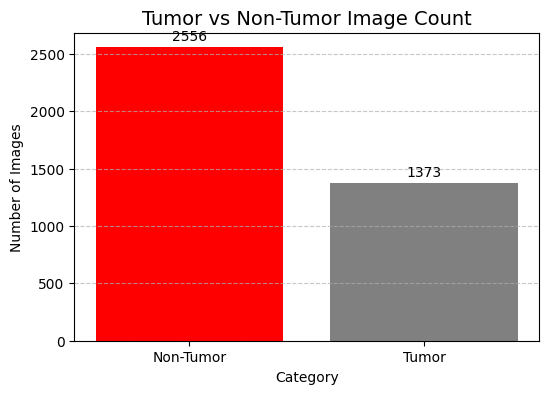

Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)
Train: (3143, 128, 128, 3) (3143, 128, 128, 1)
Val: (393, 128, 128, 3) (393, 128, 128, 1)
Test: (393, 128, 128, 3) (393, 128, 128, 1)


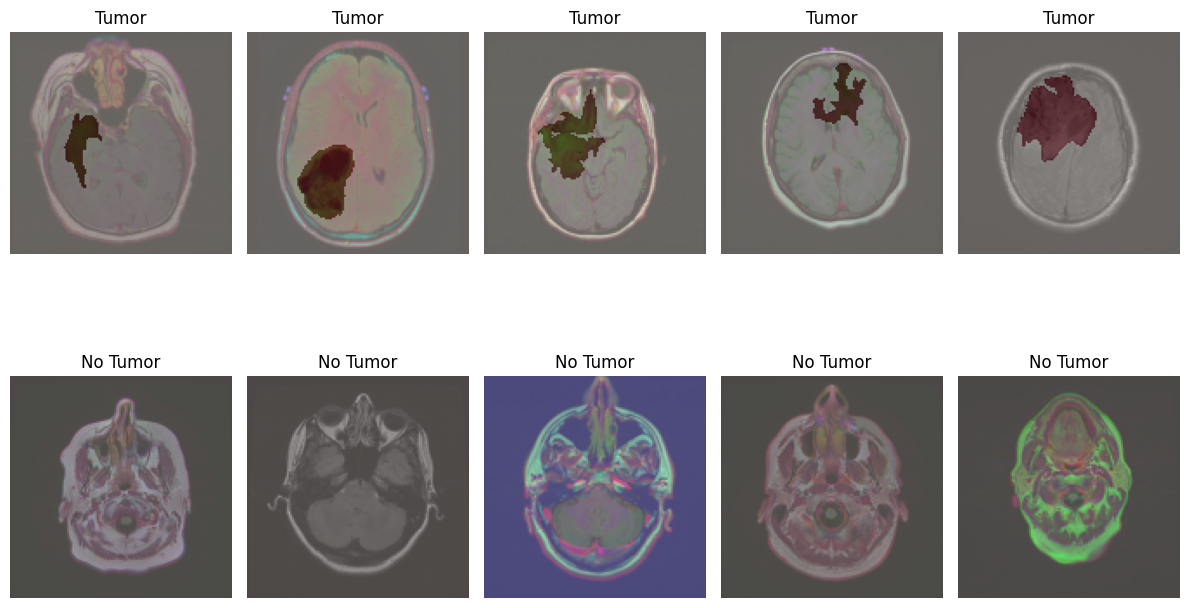

/home/stud/fmarchetto/myenv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Epoch 1/50 - Train:   0%|                               | 0/197 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 1/50 - Train:   2%|▎                      | 3/197 [00:00<00:51,  3.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   3%|▌                      | 5/197 [00:01<00:31,  6.02it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   5%|█                      | 9/197 [00:01<00:21,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   6%|█▏                    | 11/197 [00:01<00:20,  9.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   7%|█▍                    | 13/197 [00:01<00:19,  9.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   8%|█▋                    | 15/197 [00:02<00:19,  9.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:   9%|█▉                    | 17/197 [00:02<00:18,  9.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  10%|██                    | 19/197 [00:02<00:18,  9.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  11%|██▎                   | 21/197 [00:02<00:18,  9.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  12%|██▋                   | 24/197 [00:02<00:17,  9.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  13%|██▊                   | 25/197 [00:03<00:17,  9.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  14%|███                   | 27/197 [00:03<00:18,  9.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  15%|███▏                  | 29/197 [00:03<00:18,  9.00it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  17%|███▋                  | 33/197 [00:04<00:18,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  18%|███▉                  | 35/197 [00:04<00:19,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  20%|████▎                 | 39/197 [00:04<00:19,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  22%|████▊                 | 43/197 [00:05<00:18,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  24%|█████▏                | 47/197 [00:05<00:17,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  26%|█████▋                | 51/197 [00:06<00:17,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  27%|█████▉                | 53/197 [00:06<00:17,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  28%|██████▏               | 55/197 [00:06<00:17,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  29%|██████▎               | 57/197 [00:06<00:17,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  30%|██████▌               | 59/197 [00:07<00:16,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  31%|██████▊               | 61/197 [00:07<00:16,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  34%|███████▍              | 67/197 [00:08<00:15,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  35%|███████▋              | 69/197 [00:08<00:14,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  36%|███████▉              | 71/197 [00:08<00:14,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  39%|████████▌             | 77/197 [00:09<00:14,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  43%|█████████▍            | 85/197 [00:10<00:13,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:12,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  47%|██████████▍           | 93/197 [00:11<00:12,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:12,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  51%|██████████▊          | 101/197 [00:12<00:10,  8.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  52%|██████████▉          | 103/197 [00:12<00:10,  8.96it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:10,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  56%|███████████▊         | 111/197 [00:13<00:09,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  57%|████████████         | 113/197 [00:13<00:10,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  60%|████████████▋        | 119/197 [00:14<00:09,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:09,  8.10it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  62%|█████████████        | 123/197 [00:14<00:09,  8.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  64%|█████████████▌       | 127/197 [00:15<00:08,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:07,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  69%|██████████████▍      | 135/197 [00:16<00:07,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:07,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  73%|███████████████▏     | 143/197 [00:17<00:06,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:05,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  77%|████████████████     | 151/197 [00:18<00:05,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  78%|████████████████▎    | 153/197 [00:18<00:05,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:04,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  82%|█████████████████▏   | 161/197 [00:19<00:04,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:04,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  86%|██████████████████   | 169/197 [00:20<00:03,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  90%|██████████████████▊  | 177/197 [00:21<00:02,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  91%|███████████████████  | 179/197 [00:21<00:02,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  95%|████████████████████ | 188/197 [00:22<00:00,  9.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  9.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  9.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  9.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  99%|████████████████████▊| 195/197 [00:23<00:00,  8.93it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 1/50 - Train:  99%|████████████████████▉| 196/197 [00:23<00:00,  9.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 1/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.09it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 1/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 33.33it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 1/50 - Val:  76%|███████████████████      | 19/25 [00:00<00:00, 35.16it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 1/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 34.29it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Epoch 1: Train Loss = 1.2300, Val Loss = 1.1111, Val Dice = 0.6874, Val IoU = 0.5313, Train Acc = 0.9674, Val Acc = 0.9935
Saved best model!


Epoch 2/50 - Train:   1%|▏                      | 2/197 [00:00<00:15, 12.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   2%|▍                      | 4/197 [00:00<00:16, 11.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   4%|▉                      | 8/197 [00:00<00:16, 11.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   5%|█                     | 10/197 [00:00<00:16, 11.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   7%|█▌                    | 14/197 [00:01<00:16, 11.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   8%|█▊                    | 16/197 [00:01<00:16, 11.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:   9%|██                    | 18/197 [00:01<00:16, 10.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  10%|██▏                   | 20/197 [00:01<00:16, 10.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  11%|██▍                   | 22/197 [00:02<00:16, 10.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  12%|██▋                   | 24/197 [00:02<00:17,  9.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  13%|██▉                   | 26/197 [00:02<00:18,  9.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  14%|███▏                  | 28/197 [00:02<00:18,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  15%|███▎                  | 30/197 [00:02<00:19,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  16%|███▌                  | 32/197 [00:03<00:19,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  17%|███▊                  | 34/197 [00:03<00:19,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  18%|████                  | 36/197 [00:03<00:18,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  19%|████▏                 | 38/197 [00:03<00:18,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  20%|████▍                 | 40/197 [00:04<00:18,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  21%|████▋                 | 42/197 [00:04<00:18,  8.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  22%|████▉                 | 44/197 [00:04<00:18,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  23%|█████▏                | 46/197 [00:04<00:18,  7.95it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  24%|█████▎                | 48/197 [00:05<00:19,  7.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  25%|█████▌                | 50/197 [00:05<00:18,  7.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  26%|█████▊                | 52/197 [00:05<00:18,  7.99it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  27%|██████                | 54/197 [00:05<00:17,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  28%|██████▎               | 56/197 [00:06<00:17,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  29%|██████▍               | 58/197 [00:06<00:16,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  30%|██████▋               | 60/197 [00:06<00:16,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  31%|██████▉               | 62/197 [00:06<00:15,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  32%|███████▏              | 64/197 [00:07<00:15,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  34%|███████▎              | 66/197 [00:07<00:15,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  35%|███████▌              | 68/197 [00:07<00:15,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  36%|███████▊              | 70/197 [00:07<00:14,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  37%|████████              | 72/197 [00:07<00:14,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  38%|████████▎             | 74/197 [00:08<00:14,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  39%|████████▍             | 76/197 [00:08<00:14,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  40%|████████▋             | 78/197 [00:08<00:14,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  41%|████████▉             | 80/197 [00:08<00:13,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  42%|█████████▏            | 82/197 [00:09<00:13,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  43%|█████████▍            | 84/197 [00:09<00:13,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  44%|█████████▌            | 86/197 [00:09<00:13,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  45%|█████████▊            | 88/197 [00:09<00:12,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  46%|██████████            | 90/197 [00:10<00:13,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  47%|██████████▎           | 92/197 [00:10<00:12,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  48%|██████████▍           | 94/197 [00:10<00:10,  9.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  49%|██████████▊           | 97/197 [00:10<00:10,  9.81it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  50%|███████████           | 99/197 [00:11<00:09, 10.08it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:09, 10.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  52%|██████████▉          | 103/197 [00:11<00:09, 10.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  53%|███████████▏         | 105/197 [00:11<00:09,  9.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  54%|███████████▍         | 107/197 [00:11<00:09,  9.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:09,  9.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  56%|███████████▊         | 111/197 [00:12<00:09,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  57%|████████████         | 113/197 [00:12<00:09,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  58%|████████████▎        | 115/197 [00:12<00:09,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  60%|████████████▋        | 119/197 [00:13<00:09,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  61%|████████████▉        | 121/197 [00:13<00:08,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  62%|█████████████        | 123/197 [00:13<00:08,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  65%|█████████████▊       | 129/197 [00:14<00:07,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  66%|█████████████▉       | 131/197 [00:14<00:07,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  68%|██████████████▏      | 133/197 [00:14<00:07,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  70%|██████████████▌      | 137/197 [00:15<00:07,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  71%|██████████████▊      | 139/197 [00:15<00:06,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  72%|███████████████      | 141/197 [00:15<00:06,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  74%|███████████████▍     | 145/197 [00:16<00:06,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  75%|███████████████▋     | 147/197 [00:16<00:05,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  76%|███████████████▉     | 149/197 [00:16<00:05,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  78%|████████████████▎    | 153/197 [00:17<00:05,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  79%|████████████████▌    | 155/197 [00:17<00:04,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  80%|████████████████▋    | 157/197 [00:17<00:04,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  83%|█████████████████▍   | 163/197 [00:18<00:03,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  84%|█████████████████▌   | 165/197 [00:18<00:03,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  85%|█████████████████▊   | 167/197 [00:18<00:03,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  87%|██████████████████▏  | 171/197 [00:19<00:03,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  88%|██████████████████▍  | 173/197 [00:19<00:02,  8.06it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  89%|██████████████████▋  | 175/197 [00:19<00:02,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  91%|███████████████████  | 179/197 [00:20<00:02,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  92%|███████████████████▎ | 181/197 [00:20<00:01,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  93%|███████████████████▌ | 183/197 [00:20<00:01,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  95%|███████████████████▉ | 187/197 [00:21<00:01,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  96%|████████████████████▏| 189/197 [00:21<00:00,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  97%|████████████████████▎| 191/197 [00:21<00:00,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 2/50 - Train: 100%|█████████████████████| 197/197 [00:22<00:00,  8.75it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 2/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.15it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val:  28%|███████▎                  | 7/25 [00:00<00:00, 32.56it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 33.71it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val:  60%|███████████████          | 15/25 [00:00<00:00, 34.34it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val:  76%|███████████████████      | 19/25 [00:00<00:00, 34.35it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 2/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 34.08it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Train:   1%|                       | 1/197 [00:00<00:27,  7.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   2%|▎                      | 3/197 [00:00<00:25,  7.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   3%|▌                      | 5/197 [00:00<00:25,  7.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   4%|▊                      | 7/197 [00:00<00:24,  7.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   5%|█                      | 9/197 [00:01<00:22,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   6%|█▏                    | 11/197 [00:01<00:22,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   7%|█▍                    | 13/197 [00:01<00:21,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   8%|█▋                    | 15/197 [00:01<00:20,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:   9%|█▉                    | 17/197 [00:02<00:20,  8.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  10%|██                    | 19/197 [00:02<00:20,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  11%|██▎                   | 21/197 [00:02<00:20,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  12%|██▌                   | 23/197 [00:02<00:20,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  13%|██▊                   | 25/197 [00:02<00:19,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  14%|███                   | 27/197 [00:03<00:19,  8.87it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  15%|███▏                  | 29/197 [00:03<00:19,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  17%|███▋                  | 33/197 [00:03<00:19,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  18%|███▉                  | 35/197 [00:04<00:18,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  20%|████▎                 | 39/197 [00:04<00:18,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  22%|████▊                 | 43/197 [00:05<00:18,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  24%|█████▏                | 47/197 [00:05<00:18,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  25%|█████▍                | 49/197 [00:05<00:18,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  26%|█████▋                | 51/197 [00:06<00:17,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  27%|█████▉                | 53/197 [00:06<00:17,  8.00it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  28%|██████▏               | 55/197 [00:06<00:17,  8.08it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  29%|██████▎               | 57/197 [00:06<00:16,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  30%|██████▌               | 59/197 [00:07<00:16,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  31%|██████▊               | 61/197 [00:07<00:16,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  34%|███████▍              | 67/197 [00:08<00:15,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  35%|███████▋              | 69/197 [00:08<00:14,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  36%|███████▉              | 71/197 [00:08<00:14,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  39%|████████▌             | 77/197 [00:09<00:13,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  40%|████████▊             | 79/197 [00:09<00:14,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  43%|█████████▍            | 85/197 [00:10<00:13,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:12,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  47%|██████████▍           | 93/197 [00:11<00:12,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:11,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:12,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  51%|██████████▊          | 101/197 [00:12<00:11,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  52%|██████████▉          | 103/197 [00:12<00:11,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:10,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  56%|███████████▊         | 111/197 [00:13<00:10,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  57%|████████████         | 113/197 [00:13<00:09,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  60%|████████████▋        | 119/197 [00:14<00:08,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:08,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  62%|█████████████        | 123/197 [00:14<00:08,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  64%|█████████████▌       | 127/197 [00:15<00:08,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:07,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:07,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:05,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  78%|████████████████▎    | 153/197 [00:18<00:05,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:04,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  82%|█████████████████▏   | 161/197 [00:19<00:04,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:03,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  91%|███████████████████  | 179/197 [00:21<00:02,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  95%|███████████████████▉ | 187/197 [00:22<00:01,  8.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  8.96it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 3/50 - Train: 100%|█████████████████████| 197/197 [00:23<00:00,  8.49it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 3/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.26it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Val:  28%|███████▎                  | 7/25 [00:00<00:00, 32.34it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 35.19it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Val:  64%|████████████████         | 16/25 [00:00<00:00, 39.40it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 3/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 40.10it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Train:   0%|                               | 0/197 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   1%|▏                      | 2/197 [00:00<00:19, 10.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 4/50 - Train:   2%|▍                      | 4/197 [00:00<00:19, 10.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   3%|▋                      | 6/197 [00:00<00:19, 10.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   4%|▉                      | 8/197 [00:00<00:19,  9.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   5%|█                      | 9/197 [00:00<00:19,  9.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   6%|█▏                    | 11/197 [00:01<00:20,  9.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   7%|█▍                    | 13/197 [00:01<00:20,  8.96it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   8%|█▋                    | 15/197 [00:01<00:20,  8.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:   9%|█▉                    | 17/197 [00:01<00:21,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  10%|██                    | 19/197 [00:02<00:21,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  11%|██▎                   | 21/197 [00:02<00:21,  8.20it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  12%|██▌                   | 23/197 [00:02<00:21,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  13%|██▊                   | 25/197 [00:02<00:21,  8.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  14%|███                   | 27/197 [00:03<00:20,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  15%|███▏                  | 29/197 [00:03<00:20,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  17%|███▋                  | 33/197 [00:03<00:19,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  18%|███▉                  | 35/197 [00:04<00:18,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  20%|████▎                 | 39/197 [00:04<00:18,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  22%|████▊                 | 43/197 [00:04<00:18,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  23%|█████                 | 45/197 [00:05<00:17,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  24%|█████▏                | 47/197 [00:05<00:17,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  26%|█████▋                | 51/197 [00:05<00:17,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  27%|█████▉                | 53/197 [00:06<00:16,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  28%|██████▏               | 55/197 [00:06<00:16,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  29%|██████▎               | 57/197 [00:06<00:16,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  30%|██████▌               | 59/197 [00:06<00:16,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  31%|██████▊               | 61/197 [00:07<00:16,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  32%|███████               | 63/197 [00:07<00:16,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  35%|███████▋              | 69/197 [00:08<00:14,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  36%|███████▉              | 71/197 [00:08<00:14,  8.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  39%|████████▌             | 77/197 [00:08<00:13,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  43%|█████████▍            | 85/197 [00:09<00:12,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:12,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  47%|██████████▍           | 93/197 [00:10<00:12,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:12,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:11,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  52%|██████████▉          | 103/197 [00:11<00:10,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:11,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  56%|███████████▊         | 111/197 [00:12<00:09,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  57%|████████████         | 113/197 [00:13<00:09,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  60%|████████████▋        | 119/197 [00:13<00:09,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:09,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  62%|█████████████        | 123/197 [00:14<00:09,  7.99it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:07,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:07,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:05,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  78%|████████████████▎    | 153/197 [00:17<00:05,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:04,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:04,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  91%|███████████████████  | 179/197 [00:20<00:02,  8.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.87it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.81it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  95%|███████████████████▉ | 187/197 [00:21<00:01,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 4/50 - Train: 100%|█████████████████████| 197/197 [00:22<00:00,  8.57it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 4/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val:  16%|████▏                     | 4/25 [00:00<00:00, 32.13it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val:  32%|████████▎                 | 8/25 [00:00<00:00, 33.16it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val:  48%|████████████             | 12/25 [00:00<00:00, 33.62it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val:  64%|████████████████         | 16/25 [00:00<00:00, 34.01it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val:  80%|████████████████████     | 20/25 [00:00<00:00, 35.06it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 4/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 36.09it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Train:   1%|                       | 1/197 [00:00<00:22,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   2%|▎                      | 3/197 [00:00<00:23,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   3%|▌                      | 5/197 [00:00<00:22,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   4%|▊                      | 7/197 [00:00<00:22,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   5%|█                      | 9/197 [00:01<00:21,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   6%|█▏                    | 11/197 [00:01<00:21,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   7%|█▍                    | 13/197 [00:01<00:21,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   8%|█▋                    | 15/197 [00:01<00:22,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:   9%|█▉                    | 17/197 [00:02<00:21,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  10%|██                    | 19/197 [00:02<00:20,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  11%|██▎                   | 21/197 [00:02<00:20,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  12%|██▌                   | 23/197 [00:02<00:21,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  13%|██▊                   | 25/197 [00:02<00:20,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  14%|███                   | 27/197 [00:03<00:19,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  15%|███▏                  | 29/197 [00:03<00:19,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  17%|███▋                  | 33/197 [00:03<00:18,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  18%|███▉                  | 35/197 [00:04<00:18,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  20%|████▎                 | 39/197 [00:04<00:18,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  22%|████▊                 | 43/197 [00:05<00:17,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  24%|█████▏                | 47/197 [00:05<00:18,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  26%|█████▋                | 51/197 [00:05<00:16,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  27%|█████▉                | 53/197 [00:06<00:15,  9.06it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  28%|██████▏               | 55/197 [00:06<00:15,  8.94it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  29%|██████▎               | 57/197 [00:06<00:15,  8.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  30%|██████▌               | 59/197 [00:06<00:15,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  31%|██████▊               | 61/197 [00:07<00:15,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  35%|███████▋              | 69/197 [00:08<00:15,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  36%|███████▉              | 71/197 [00:08<00:15,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  39%|████████▌             | 77/197 [00:09<00:14,  8.08it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  43%|█████████▍            | 85/197 [00:09<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:13,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  47%|██████████▍           | 93/197 [00:10<00:12,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:11,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:11,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  52%|██████████▉          | 103/197 [00:12<00:10,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:10,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  56%|███████████▊         | 111/197 [00:13<00:10,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  57%|████████████         | 113/197 [00:13<00:09,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  60%|████████████▋        | 119/197 [00:13<00:09,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:09,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  62%|█████████████        | 123/197 [00:14<00:08,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:08,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:06,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:05,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  78%|████████████████▎    | 153/197 [00:17<00:05,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:05,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:03,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  91%|███████████████████  | 179/197 [00:21<00:02,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  95%|███████████████████▉ | 187/197 [00:21<00:01,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.81it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 5/50 - Train: 100%|█████████████████████| 197/197 [00:23<00:00,  8.53it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 5/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.46it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val:  28%|███████▎                  | 7/25 [00:00<00:00, 32.19it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 32.45it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val:  60%|███████████████          | 15/25 [00:00<00:00, 33.78it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val:  76%|███████████████████      | 19/25 [00:00<00:00, 33.98it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 5/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 33.78it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Saved best model!


Epoch 6/50 - Train:   1%|                       | 1/197 [00:00<00:26,  7.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   2%|▎                      | 3/197 [00:00<00:23,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   3%|▌                      | 5/197 [00:00<00:23,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   4%|▊                      | 7/197 [00:00<00:23,  8.20it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   5%|█                      | 9/197 [00:01<00:22,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   6%|█▏                    | 11/197 [00:01<00:21,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   7%|█▍                    | 13/197 [00:01<00:21,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   8%|█▋                    | 15/197 [00:01<00:22,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:   9%|█▉                    | 17/197 [00:02<00:21,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  10%|██                    | 19/197 [00:02<00:20,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  11%|██▎                   | 21/197 [00:02<00:20,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  12%|██▌                   | 23/197 [00:02<00:20,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  13%|██▊                   | 25/197 [00:02<00:19,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  14%|███                   | 27/197 [00:03<00:19,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  15%|███▏                  | 29/197 [00:03<00:19,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  17%|███▋                  | 33/197 [00:03<00:19,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  18%|███▉                  | 35/197 [00:04<00:19,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  20%|████▎                 | 39/197 [00:04<00:19,  8.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  21%|████▌                 | 41/197 [00:04<00:19,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  22%|████▊                 | 43/197 [00:05<00:18,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  24%|█████▏                | 47/197 [00:05<00:17,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  25%|█████▍                | 49/197 [00:05<00:18,  8.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  26%|█████▋                | 51/197 [00:06<00:17,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  27%|█████▉                | 53/197 [00:06<00:17,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  28%|██████▏               | 55/197 [00:06<00:17,  7.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  29%|██████▎               | 57/197 [00:06<00:17,  8.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  30%|██████▌               | 59/197 [00:07<00:16,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  31%|██████▊               | 61/197 [00:07<00:16,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  35%|███████▋              | 69/197 [00:08<00:14,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  36%|███████▉              | 71/197 [00:08<00:14,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  39%|████████▌             | 77/197 [00:09<00:13,  8.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  43%|█████████▍            | 85/197 [00:10<00:13,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:12,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  47%|██████████▍           | 93/197 [00:11<00:11,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:11,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.80it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:10,  9.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  52%|██████████▉          | 103/197 [00:12<00:10,  8.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:10,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  56%|███████████▊         | 111/197 [00:13<00:10,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  57%|████████████         | 113/197 [00:13<00:09,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  60%|████████████▋        | 119/197 [00:14<00:09,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:09,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  62%|█████████████        | 123/197 [00:14<00:08,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.08it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:07,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  9.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:06,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:05,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  78%|████████████████▎    | 153/197 [00:17<00:05,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:04,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:04,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  91%|███████████████████  | 179/197 [00:21<00:02,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  9.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  95%|███████████████████▉ | 187/197 [00:21<00:01,  9.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  9.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  9.00it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.91it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 6/50 - Train: 100%|█████████████████████| 197/197 [00:23<00:00,  8.54it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 6/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.98it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 6/50 - Val:  28%|███████▎                  | 7/25 [00:00<00:00, 32.77it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 6/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 33.63it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 6/50 - Val:  60%|███████████████          | 15/25 [00:00<00:00, 34.30it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 6/50 - Val:  76%|███████████████████      | 19/25 [00:00<00:00, 34.36it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 6/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 34.19it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Train:   1%|                       | 1/197 [00:00<00:24,  8.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   2%|▎                      | 3/197 [00:00<00:23,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   3%|▌                      | 5/197 [00:00<00:24,  7.94it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   4%|▊                      | 7/197 [00:00<00:23,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   5%|█                      | 9/197 [00:01<00:22,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   6%|█▏                    | 11/197 [00:01<00:22,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   7%|█▍                    | 13/197 [00:01<00:21,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   8%|█▋                    | 15/197 [00:01<00:21,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:   9%|█▉                    | 17/197 [00:02<00:21,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  10%|██                    | 19/197 [00:02<00:21,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  11%|██▎                   | 21/197 [00:02<00:20,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  12%|██▌                   | 23/197 [00:02<00:21,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  13%|██▊                   | 25/197 [00:03<00:21,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  14%|███                   | 27/197 [00:03<00:20,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  15%|███▏                  | 29/197 [00:03<00:18,  8.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  17%|███▋                  | 33/197 [00:03<00:18,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  18%|███▉                  | 35/197 [00:04<00:18,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  19%|████▏                 | 37/197 [00:04<00:17,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  20%|████▎                 | 39/197 [00:04<00:18,  8.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  22%|████▊                 | 43/197 [00:05<00:18,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  24%|█████▏                | 47/197 [00:05<00:18,  8.06it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  26%|█████▋                | 51/197 [00:06<00:16,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  27%|█████▉                | 53/197 [00:06<00:16,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  28%|██████▏               | 55/197 [00:06<00:16,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  29%|██████▎               | 57/197 [00:06<00:16,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  30%|██████▌               | 59/197 [00:06<00:15,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  31%|██████▊               | 61/197 [00:07<00:15,  8.71it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  35%|███████▋              | 69/197 [00:08<00:15,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  36%|███████▉              | 71/197 [00:08<00:15,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  37%|████████▏             | 73/197 [00:08<00:15,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  39%|████████▌             | 77/197 [00:09<00:14,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  43%|█████████▍            | 85/197 [00:10<00:12,  8.81it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  44%|█████████▋            | 87/197 [00:10<00:12,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:12,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  47%|██████████▍           | 93/197 [00:10<00:12,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  48%|██████████▌           | 95/197 [00:11<00:11,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:11,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  52%|██████████▉          | 103/197 [00:12<00:11,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  53%|███████████▏         | 105/197 [00:12<00:11,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  56%|███████████▊         | 111/197 [00:13<00:10,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  57%|████████████         | 113/197 [00:13<00:10,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  60%|████████████▋        | 119/197 [00:14<00:09,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  61%|████████████▉        | 121/197 [00:14<00:08,  8.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  62%|█████████████        | 123/197 [00:14<00:08,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  65%|█████████████▊       | 129/197 [00:15<00:08,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  70%|██████████████▌      | 137/197 [00:16<00:06,  8.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  71%|██████████████▊      | 139/197 [00:16<00:06,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  74%|███████████████▍     | 145/197 [00:17<00:06,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  75%|███████████████▋     | 147/197 [00:17<00:06,  8.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  78%|████████████████▎    | 153/197 [00:18<00:05,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  79%|████████████████▌    | 155/197 [00:18<00:05,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  83%|█████████████████▍   | 163/197 [00:19<00:03,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  84%|█████████████████▌   | 165/197 [00:19<00:03,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  87%|██████████████████▏  | 171/197 [00:20<00:03,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  88%|██████████████████▍  | 173/197 [00:20<00:02,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  91%|███████████████████  | 179/197 [00:21<00:02,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  92%|███████████████████▎ | 181/197 [00:21<00:01,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  95%|███████████████████▉ | 187/197 [00:22<00:01,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  96%|████████████████████▏| 189/197 [00:22<00:00,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train:  99%|████████████████████▊| 195/197 [00:23<00:00,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 7/50 - Train: 100%|█████████████████████| 197/197 [00:23<00:00,  8.47it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 7/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 27.87it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val:  28%|███████▎                  | 7/25 [00:00<00:00, 31.59it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val:  44%|███████████              | 11/25 [00:00<00:00, 33.10it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val:  60%|███████████████          | 15/25 [00:00<00:00, 34.16it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val:  76%|███████████████████      | 19/25 [00:00<00:00, 35.52it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 7/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 36.46it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Epoch 7: Train Loss = 0.7496, Val Loss = 0.7461, Val Dice = 0.8565, Val IoU = 0.7540, Train Acc = 0.9967, Val Acc = 0.9974
Saved best model!


Epoch 8/50 - Train:   1%|▏                      | 2/197 [00:00<00:17, 10.98it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   2%|▍                      | 4/197 [00:00<00:18, 10.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   3%|▋                      | 6/197 [00:00<00:17, 10.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   4%|▉                      | 8/197 [00:00<00:17, 10.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   6%|█▎                    | 12/197 [00:01<00:17, 10.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   7%|█▌                    | 14/197 [00:01<00:17, 10.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   8%|█▊                    | 16/197 [00:01<00:17, 10.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:   9%|██                    | 18/197 [00:01<00:17, 10.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  10%|██▏                   | 20/197 [00:01<00:17,  9.94it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  11%|██▎                   | 21/197 [00:02<00:17,  9.87it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  12%|██▌                   | 23/197 [00:02<00:18,  9.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  13%|██▊                   | 25/197 [00:02<00:19,  8.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  14%|███                   | 27/197 [00:02<00:20,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  15%|███▏                  | 29/197 [00:03<00:20,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  16%|███▍                  | 31/197 [00:03<00:20,  8.05it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  17%|███▋                  | 33/197 [00:03<00:20,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  18%|███▉                  | 35/197 [00:03<00:19,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  19%|████▏                 | 37/197 [00:03<00:18,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  20%|████▎                 | 39/197 [00:04<00:19,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  22%|████▊                 | 43/197 [00:04<00:17,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  23%|█████                 | 45/197 [00:04<00:18,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  24%|█████▏                | 47/197 [00:05<00:17,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  26%|█████▋                | 51/197 [00:05<00:17,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  27%|█████▉                | 53/197 [00:05<00:16,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  28%|██████▏               | 55/197 [00:06<00:16,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  29%|██████▎               | 57/197 [00:06<00:16,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  30%|██████▌               | 59/197 [00:06<00:15,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  31%|██████▊               | 61/197 [00:06<00:15,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  35%|███████▋              | 69/197 [00:07<00:14,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  36%|███████▉              | 71/197 [00:07<00:15,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  37%|████████▏             | 73/197 [00:08<00:15,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  39%|████████▌             | 77/197 [00:08<00:13,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  40%|████████▊             | 79/197 [00:08<00:13,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  42%|█████████▎            | 83/197 [00:09<00:13,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  43%|█████████▍            | 85/197 [00:09<00:13,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  44%|█████████▋            | 87/197 [00:09<00:13,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  45%|█████████▉            | 89/197 [00:10<00:13,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  46%|██████████▏           | 91/197 [00:10<00:12,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  47%|██████████▍           | 93/197 [00:10<00:12,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  48%|██████████▌           | 95/197 [00:10<00:11,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  49%|██████████▊           | 97/197 [00:11<00:11,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  50%|███████████           | 99/197 [00:11<00:11,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  51%|██████████▊          | 101/197 [00:11<00:11,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  52%|██████████▉          | 103/197 [00:11<00:11,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  53%|███████████▏         | 105/197 [00:11<00:10,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  54%|███████████▍         | 107/197 [00:12<00:10,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  55%|███████████▌         | 109/197 [00:12<00:10,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  56%|███████████▊         | 111/197 [00:12<00:09,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  57%|████████████         | 113/197 [00:12<00:09,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  58%|████████████▎        | 115/197 [00:13<00:09,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  59%|████████████▍        | 117/197 [00:13<00:09,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  60%|████████████▋        | 119/197 [00:13<00:09,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  61%|████████████▉        | 121/197 [00:13<00:08,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  62%|█████████████        | 123/197 [00:14<00:08,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  63%|█████████████▎       | 125/197 [00:14<00:08,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  64%|█████████████▌       | 127/197 [00:14<00:08,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  65%|█████████████▊       | 129/197 [00:14<00:08,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  66%|█████████████▉       | 131/197 [00:15<00:07,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  68%|██████████████▏      | 133/197 [00:15<00:07,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  69%|██████████████▍      | 135/197 [00:15<00:07,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  70%|██████████████▌      | 137/197 [00:15<00:06,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  71%|██████████████▊      | 139/197 [00:15<00:06,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  72%|███████████████      | 141/197 [00:16<00:06,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  73%|███████████████▏     | 143/197 [00:16<00:06,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  74%|███████████████▍     | 145/197 [00:16<00:06,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  75%|███████████████▋     | 147/197 [00:16<00:06,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  76%|███████████████▉     | 149/197 [00:17<00:05,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  77%|████████████████     | 151/197 [00:17<00:05,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  78%|████████████████▎    | 153/197 [00:17<00:04,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  79%|████████████████▌    | 155/197 [00:17<00:04,  8.81it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  80%|████████████████▋    | 157/197 [00:18<00:04,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  81%|████████████████▉    | 159/197 [00:18<00:04,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  82%|█████████████████▏   | 161/197 [00:18<00:04,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  83%|█████████████████▍   | 163/197 [00:18<00:04,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  84%|█████████████████▌   | 165/197 [00:18<00:03,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  85%|█████████████████▊   | 167/197 [00:19<00:03,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  86%|██████████████████   | 169/197 [00:19<00:03,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  87%|██████████████████▏  | 171/197 [00:19<00:03,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  88%|██████████████████▍  | 173/197 [00:19<00:02,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  89%|██████████████████▋  | 175/197 [00:20<00:02,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  90%|██████████████████▊  | 177/197 [00:20<00:02,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  91%|███████████████████  | 179/197 [00:20<00:02,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  92%|███████████████████▎ | 181/197 [00:20<00:01,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  93%|███████████████████▌ | 183/197 [00:21<00:01,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  94%|███████████████████▋ | 185/197 [00:21<00:01,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  95%|███████████████████▉ | 187/197 [00:21<00:01,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  96%|████████████████████▏| 189/197 [00:21<00:00,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  97%|████████████████████▎| 191/197 [00:22<00:00,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  98%|████████████████████▌| 193/197 [00:22<00:00,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train:  99%|████████████████████▊| 195/197 [00:22<00:00,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 8/50 - Train: 100%|█████████████████████| 197/197 [00:22<00:00,  8.67it/s]


Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 8/50 - Val:   0%|                                  | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val:  16%|████▏                     | 4/25 [00:00<00:00, 31.45it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val:  32%|████████▎                 | 8/25 [00:00<00:00, 34.29it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val:  48%|████████████             | 12/25 [00:00<00:00, 34.50it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val:  64%|████████████████         | 16/25 [00:00<00:00, 33.80it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val:  80%|████████████████████     | 20/25 [00:00<00:00, 34.28it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 8/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 35.76it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Saved best model!


Epoch 9/50 - Train:   1%|                       | 1/197 [00:00<00:24,  7.95it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   2%|▎                      | 3/197 [00:00<00:24,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   3%|▌                      | 5/197 [00:00<00:23,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   4%|▊                      | 7/197 [00:00<00:22,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   5%|█                      | 9/197 [00:01<00:22,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   6%|█▏                    | 11/197 [00:01<00:21,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   7%|█▍                    | 13/197 [00:01<00:21,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   8%|█▋                    | 15/197 [00:01<00:21,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:   9%|█▉                    | 17/197 [00:02<00:21,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  10%|██                    | 19/197 [00:02<00:21,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  11%|██▎                   | 21/197 [00:02<00:21,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  12%|██▌                   | 23/197 [00:02<00:20,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  13%|██▊                   | 25/197 [00:02<00:20,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  14%|███                   | 27/197 [00:03<00:20,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  15%|███▏                  | 29/197 [00:03<00:20,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  16%|███▍                  | 31/197 [00:03<00:19,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  17%|███▋                  | 33/197 [00:03<00:19,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  18%|███▉                  | 35/197 [00:04<00:19,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  19%|████▏                 | 37/197 [00:04<00:18,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  20%|████▎                 | 39/197 [00:04<00:18,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  21%|████▌                 | 41/197 [00:04<00:18,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  22%|████▊                 | 43/197 [00:05<00:18,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  23%|█████                 | 45/197 [00:05<00:18,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  24%|█████▏                | 47/197 [00:05<00:17,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  25%|█████▍                | 49/197 [00:05<00:17,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  26%|█████▋                | 51/197 [00:06<00:16,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  27%|█████▉                | 53/197 [00:06<00:16,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  28%|██████▏               | 55/197 [00:06<00:16,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  29%|██████▎               | 57/197 [00:06<00:16,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  30%|██████▌               | 59/197 [00:07<00:16,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  31%|██████▊               | 61/197 [00:07<00:16,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  32%|███████               | 63/197 [00:07<00:15,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  33%|███████▎              | 65/197 [00:07<00:15,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  34%|███████▍              | 67/197 [00:07<00:15,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  35%|███████▋              | 69/197 [00:08<00:14,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  36%|███████▉              | 71/197 [00:08<00:15,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  37%|████████▏             | 73/197 [00:08<00:14,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  38%|████████▍             | 75/197 [00:08<00:14,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  39%|████████▌             | 77/197 [00:09<00:13,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  40%|████████▊             | 79/197 [00:09<00:13,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  41%|█████████             | 81/197 [00:09<00:13,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  42%|█████████▏            | 82/197 [00:09<00:13,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 9/50 - Train:  43%|█████████▍            | 84/197 [00:10<00:15,  7.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  44%|█████████▌            | 86/197 [00:10<00:13,  7.93it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  45%|█████████▊            | 88/197 [00:10<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  46%|██████████            | 90/197 [00:10<00:13,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  47%|██████████▎           | 92/197 [00:10<00:12,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  48%|██████████▍           | 94/197 [00:11<00:14,  7.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  49%|██████████▋           | 96/197 [00:11<00:12,  8.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  50%|██████████▉           | 98/197 [00:11<00:11,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  51%|██████████▋          | 100/197 [00:11<00:11,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  52%|██████████▊          | 102/197 [00:12<00:10,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  53%|███████████          | 104/197 [00:12<00:10,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  54%|███████████▎         | 106/197 [00:12<00:12,  7.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  55%|███████████▌         | 108/197 [00:12<00:11,  8.06it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  56%|███████████▋         | 110/197 [00:13<00:10,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  57%|███████████▉         | 112/197 [00:13<00:10,  7.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  58%|████████████▏        | 114/197 [00:13<00:09,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  59%|████████████▎        | 116/197 [00:13<00:09,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  60%|████████████▌        | 118/197 [00:14<00:09,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  61%|████████████▊        | 120/197 [00:14<00:09,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  62%|█████████████        | 122/197 [00:14<00:08,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  63%|█████████████▏       | 124/197 [00:14<00:08,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  64%|█████████████▍       | 126/197 [00:15<00:08,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  65%|█████████████▋       | 128/197 [00:15<00:08,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  66%|█████████████▊       | 130/197 [00:15<00:08,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  67%|██████████████       | 132/197 [00:15<00:07,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  68%|██████████████▎      | 134/197 [00:16<00:07,  8.51it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  69%|██████████████▍      | 136/197 [00:16<00:07,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  70%|██████████████▋      | 138/197 [00:16<00:07,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  71%|██████████████▉      | 140/197 [00:16<00:07,  8.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  72%|███████████████▏     | 142/197 [00:17<00:06,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  73%|███████████████▎     | 144/197 [00:17<00:06,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  74%|███████████████▌     | 146/197 [00:17<00:06,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  75%|███████████████▊     | 148/197 [00:17<00:05,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  76%|███████████████▉     | 150/197 [00:17<00:05,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  77%|████████████████▏    | 152/197 [00:18<00:05,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  78%|████████████████▍    | 154/197 [00:18<00:04,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  79%|████████████████▋    | 156/197 [00:18<00:04,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  80%|████████████████▊    | 158/197 [00:18<00:04,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  81%|█████████████████    | 160/197 [00:19<00:04,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  82%|█████████████████▎   | 162/197 [00:19<00:04,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  83%|█████████████████▍   | 164/197 [00:19<00:03,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  84%|█████████████████▋   | 166/197 [00:19<00:03,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  85%|█████████████████▉   | 168/197 [00:20<00:03,  8.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  86%|██████████████████   | 170/197 [00:20<00:03,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  87%|██████████████████▎  | 172/197 [00:20<00:02,  8.48it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  88%|██████████████████▌  | 174/197 [00:20<00:02,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  89%|██████████████████▊  | 176/197 [00:21<00:02,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  90%|██████████████████▉  | 178/197 [00:21<00:02,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  91%|███████████████████▏ | 180/197 [00:21<00:02,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  92%|███████████████████▍ | 182/197 [00:21<00:01,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  93%|███████████████████▌ | 184/197 [00:21<00:01,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  94%|███████████████████▊ | 186/197 [00:22<00:01,  8.62it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  95%|████████████████████ | 188/197 [00:22<00:01,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  96%|████████████████████▎| 190/197 [00:22<00:00,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  97%|████████████████████▍| 192/197 [00:22<00:00,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  98%|████████████████████▋| 194/197 [00:23<00:00,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Train:  99%|████████████████████▉| 196/197 [00:23<00:00,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 9/50 - Val:  12%|███                       | 3/25 [00:00<00:00, 29.19it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 9/50 - Val:  48%|████████████             | 12/25 [00:00<00:00, 37.94it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 9/50 - Val: 100%|█████████████████████████| 25/25 [00:00<00:00, 40.78it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Train:   1%|                      | 1/197 [00:00<00:22,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   2%|▎                     | 3/197 [00:00<00:20,  9.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   3%|▌                     | 5/197 [00:00<00:20,  9.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   4%|▊                     | 7/197 [00:00<00:21,  8.91it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   5%|█                     | 9/197 [00:01<00:21,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   6%|█▏                   | 11/197 [00:01<00:21,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   7%|█▍                   | 13/197 [00:01<00:21,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   8%|█▌                   | 15/197 [00:01<00:21,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:   9%|█▊                   | 17/197 [00:01<00:21,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  10%|██                   | 19/197 [00:02<00:21,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  11%|██▏                  | 21/197 [00:02<00:20,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  12%|██▍                  | 23/197 [00:02<00:20,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  13%|██▋                  | 25/197 [00:02<00:20,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  14%|██▉                  | 27/197 [00:03<00:19,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  15%|███                  | 29/197 [00:03<00:19,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  16%|███▎                 | 31/197 [00:03<00:19,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  17%|███▌                 | 33/197 [00:03<00:18,  8.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  18%|███▋                 | 35/197 [00:04<00:18,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  19%|███▉                 | 37/197 [00:04<00:18,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  20%|████▏                | 39/197 [00:04<00:17,  8.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  21%|████▎                | 41/197 [00:04<00:17,  8.80it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  22%|████▌                | 43/197 [00:04<00:17,  8.93it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  23%|████▊                | 45/197 [00:05<00:17,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  24%|█████                | 47/197 [00:05<00:17,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  25%|█████▏               | 49/197 [00:05<00:16,  8.87it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  26%|█████▍               | 51/197 [00:05<00:15,  9.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  27%|█████▋               | 53/197 [00:06<00:15,  9.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  28%|█████▊               | 55/197 [00:06<00:16,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  29%|██████               | 57/197 [00:06<00:15,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  30%|██████▎              | 59/197 [00:06<00:15,  8.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  31%|██████▌              | 61/197 [00:07<00:15,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  32%|██████▋              | 63/197 [00:07<00:15,  8.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  33%|██████▉              | 65/197 [00:07<00:15,  8.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  34%|███████▏             | 67/197 [00:07<00:14,  8.80it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  35%|███████▎             | 69/197 [00:07<00:15,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  36%|███████▌             | 71/197 [00:08<00:14,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  37%|███████▊             | 73/197 [00:08<00:14,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  38%|███████▉             | 75/197 [00:08<00:13,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  39%|████████▏            | 77/197 [00:08<00:14,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  40%|████████▍            | 79/197 [00:09<00:13,  8.68it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  41%|████████▋            | 81/197 [00:09<00:13,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  42%|████████▊            | 83/197 [00:09<00:13,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  43%|█████████            | 85/197 [00:09<00:12,  8.73it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  44%|█████████▎           | 87/197 [00:10<00:12,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  45%|█████████▍           | 89/197 [00:10<00:12,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  46%|█████████▋           | 91/197 [00:10<00:12,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  47%|█████████▉           | 93/197 [00:10<00:12,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  48%|██████████▏          | 95/197 [00:10<00:12,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  49%|██████████▎          | 97/197 [00:11<00:11,  8.65it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  50%|██████████▌          | 99/197 [00:11<00:11,  8.82it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  51%|██████████▎         | 101/197 [00:11<00:10,  8.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  52%|██████████▍         | 103/197 [00:11<00:10,  8.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  53%|██████████▋         | 105/197 [00:12<00:10,  8.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  54%|██████████▊         | 107/197 [00:12<00:10,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  55%|███████████         | 109/197 [00:12<00:10,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  56%|███████████▎        | 111/197 [00:12<00:10,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  57%|███████████▍        | 113/197 [00:13<00:10,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  58%|███████████▋        | 115/197 [00:13<00:09,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  59%|███████████▉        | 117/197 [00:13<00:09,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  60%|████████████        | 119/197 [00:13<00:09,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  61%|████████████▎       | 121/197 [00:13<00:08,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  62%|████████████▍       | 123/197 [00:14<00:08,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  63%|████████████▋       | 125/197 [00:14<00:08,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  64%|████████████▉       | 127/197 [00:14<00:08,  8.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  65%|█████████████       | 129/197 [00:14<00:07,  8.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  66%|█████████████▎      | 131/197 [00:15<00:07,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  68%|█████████████▌      | 133/197 [00:15<00:07,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  69%|█████████████▋      | 135/197 [00:15<00:06,  8.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  70%|█████████████▉      | 137/197 [00:15<00:06,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  71%|██████████████      | 139/197 [00:16<00:06,  8.72it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  72%|██████████████▎     | 141/197 [00:16<00:06,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  73%|██████████████▌     | 143/197 [00:16<00:06,  8.50it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  74%|██████████████▋     | 145/197 [00:16<00:05,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  75%|██████████████▉     | 147/197 [00:16<00:05,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  76%|███████████████▏    | 149/197 [00:17<00:05,  8.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  77%|███████████████▎    | 151/197 [00:17<00:05,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  78%|███████████████▌    | 153/197 [00:17<00:05,  8.58it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  79%|███████████████▋    | 155/197 [00:17<00:04,  8.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  80%|███████████████▉    | 157/197 [00:18<00:04,  8.70it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  81%|████████████████▏   | 159/197 [00:18<00:04,  8.56it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  82%|████████████████▎   | 161/197 [00:18<00:04,  8.44it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  83%|████████████████▌   | 163/197 [00:18<00:04,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 10/50 - Train:  83%|████████████████▋   | 164/197 [00:18<00:04,  8.10it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  84%|████████████████▊   | 165/197 [00:19<00:04,  7.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  84%|████████████████▊   | 166/197 [00:19<00:04,  7.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  85%|████████████████▉   | 167/197 [00:19<00:03,  7.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  85%|█████████████████   | 168/197 [00:19<00:03,  7.80it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  86%|█████████████████▏  | 169/197 [00:19<00:03,  7.77it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  86%|█████████████████▎  | 170/197 [00:19<00:03,  7.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  87%|█████████████████▎  | 171/197 [00:19<00:03,  7.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  87%|█████████████████▍  | 172/197 [00:20<00:03,  7.94it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  88%|█████████████████▌  | 173/197 [00:20<00:02,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  88%|█████████████████▋  | 174/197 [00:20<00:02,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  89%|█████████████████▊  | 175/197 [00:20<00:02,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  89%|█████████████████▊  | 176/197 [00:20<00:02,  7.95it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  90%|█████████████████▉  | 177/197 [00:20<00:02,  8.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  90%|██████████████████  | 178/197 [00:20<00:02,  7.86it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  91%|██████████████████▏ | 179/197 [00:20<00:02,  7.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  91%|██████████████████▎ | 180/197 [00:20<00:02,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  92%|██████████████████▍ | 181/197 [00:21<00:01,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  92%|██████████████████▍ | 182/197 [00:21<00:01,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  93%|██████████████████▌ | 183/197 [00:21<00:01,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  93%|██████████████████▋ | 184/197 [00:21<00:01,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  94%|██████████████████▊ | 185/197 [00:21<00:01,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  94%|██████████████████▉ | 186/197 [00:21<00:01,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  95%|██████████████████▉ | 187/197 [00:21<00:01,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  95%|███████████████████ | 188/197 [00:21<00:01,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  96%|███████████████████▏| 189/197 [00:22<00:00,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  96%|███████████████████▎| 190/197 [00:22<00:00,  8.76it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  97%|███████████████████▍| 191/197 [00:22<00:00,  8.87it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  97%|███████████████████▍| 192/197 [00:22<00:00,  8.63it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  98%|███████████████████▌| 193/197 [00:22<00:00,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  98%|███████████████████▋| 194/197 [00:22<00:00,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  99%|███████████████████▊| 195/197 [00:22<00:00,  8.61it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Train:  99%|███████████████████▉| 196/197 [00:22<00:00,  8.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 10/50 - Val:   0%|                                 | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val:  12%|███                      | 3/25 [00:00<00:00, 28.33it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val:  28%|███████                  | 7/25 [00:00<00:00, 31.95it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val:  44%|██████████▌             | 11/25 [00:00<00:00, 33.29it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val:  60%|██████████████▍         | 15/25 [00:00<00:00, 34.57it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val:  76%|██████████████████▏     | 19/25 [00:00<00:00, 35.69it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 10/50 - Val: 100%|████████████████████████| 25/25 [00:00<00:00, 34.69it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Train:   0%|                              | 0/197 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   1%|                      | 1/197 [00:00<00:21,  9.10it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   1%|▏                     | 2/197 [00:00<00:22,  8.80it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   2%|▎                     | 3/197 [00:00<00:21,  8.90it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   2%|▍                     | 4/197 [00:00<00:23,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   3%|▌                     | 5/197 [00:00<00:23,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   3%|▋                     | 6/197 [00:00<00:23,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   4%|▊                     | 7/197 [00:00<00:23,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   4%|▉                     | 8/197 [00:00<00:23,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   5%|█                     | 9/197 [00:01<00:22,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   5%|█                    | 10/197 [00:01<00:22,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   6%|█▏                   | 11/197 [00:01<00:22,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   6%|█▎                   | 12/197 [00:01<00:22,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   7%|█▍                   | 13/197 [00:01<00:22,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   7%|█▍                   | 14/197 [00:01<00:21,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   8%|█▌                   | 15/197 [00:01<00:21,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   8%|█▋                   | 16/197 [00:01<00:21,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   9%|█▊                   | 17/197 [00:02<00:21,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:   9%|█▉                   | 18/197 [00:02<00:20,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  10%|██                   | 19/197 [00:02<00:20,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  10%|██▏                  | 20/197 [00:02<00:21,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  11%|██▏                  | 21/197 [00:02<00:21,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  11%|██▎                  | 22/197 [00:02<00:20,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  12%|██▍                  | 23/197 [00:02<00:20,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  12%|██▌                  | 24/197 [00:02<00:20,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  13%|██▋                  | 25/197 [00:02<00:21,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  13%|██▊                  | 26/197 [00:03<00:20,  8.17it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  14%|██▉                  | 27/197 [00:03<00:20,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  14%|██▉                  | 28/197 [00:03<00:20,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  15%|███                  | 29/197 [00:03<00:20,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  15%|███▏                 | 30/197 [00:03<00:20,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  16%|███▎                 | 31/197 [00:03<00:20,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  16%|███▍                 | 32/197 [00:03<00:19,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  17%|███▌                 | 33/197 [00:03<00:19,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  17%|███▌                 | 34/197 [00:04<00:19,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  18%|███▋                 | 35/197 [00:04<00:20,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  18%|███▊                 | 36/197 [00:04<00:20,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  19%|███▉                 | 37/197 [00:04<00:20,  7.89it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  19%|████                 | 38/197 [00:04<00:20,  7.85it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  20%|████▏                | 39/197 [00:04<00:19,  7.92it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  20%|████▎                | 40/197 [00:04<00:19,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  21%|████▎                | 41/197 [00:04<00:19,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  21%|████▍                | 42/197 [00:05<00:19,  8.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  22%|████▌                | 43/197 [00:05<00:19,  8.08it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  22%|████▋                | 44/197 [00:05<00:18,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  23%|████▊                | 45/197 [00:05<00:18,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  23%|████▉                | 46/197 [00:05<00:18,  8.05it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  24%|█████                | 47/197 [00:05<00:18,  7.98it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  24%|█████                | 48/197 [00:05<00:18,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  25%|█████▏               | 49/197 [00:05<00:18,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  25%|█████▎               | 50/197 [00:06<00:17,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  26%|█████▍               | 51/197 [00:06<00:17,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  26%|█████▌               | 52/197 [00:06<00:17,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  27%|█████▋               | 53/197 [00:06<00:17,  8.00it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  27%|█████▊               | 54/197 [00:06<00:17,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  28%|█████▊               | 55/197 [00:06<00:17,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  28%|█████▉               | 56/197 [00:06<00:16,  8.52it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  29%|██████               | 57/197 [00:06<00:16,  8.60it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  29%|██████▏              | 58/197 [00:07<00:16,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  30%|██████▎              | 59/197 [00:07<00:16,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  30%|██████▍              | 60/197 [00:07<00:16,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  31%|██████▌              | 61/197 [00:07<00:16,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  31%|██████▌              | 62/197 [00:07<00:16,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  32%|██████▋              | 63/197 [00:07<00:15,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  32%|██████▊              | 64/197 [00:07<00:15,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  33%|██████▉              | 65/197 [00:07<00:15,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  34%|███████              | 66/197 [00:07<00:15,  8.53it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  34%|███████▏             | 67/197 [00:08<00:15,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  35%|███████▏             | 68/197 [00:08<00:15,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  35%|███████▎             | 69/197 [00:08<00:15,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  36%|███████▍             | 70/197 [00:08<00:15,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  36%|███████▌             | 71/197 [00:08<00:15,  8.37it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  37%|███████▋             | 72/197 [00:08<00:14,  8.34it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  37%|███████▊             | 73/197 [00:08<00:14,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  38%|███████▉             | 74/197 [00:08<00:14,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  38%|███████▉             | 75/197 [00:09<00:14,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  39%|████████             | 76/197 [00:09<00:14,  8.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  39%|████████▏            | 77/197 [00:09<00:14,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  40%|████████▎            | 78/197 [00:09<00:13,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  40%|████████▍            | 79/197 [00:09<00:14,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  41%|████████▌            | 80/197 [00:09<00:14,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  41%|████████▋            | 81/197 [00:09<00:14,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  42%|████████▋            | 82/197 [00:09<00:14,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  42%|████████▊            | 83/197 [00:10<00:13,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  43%|████████▉            | 84/197 [00:10<00:13,  8.20it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  43%|█████████            | 85/197 [00:10<00:13,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  44%|█████████▏           | 86/197 [00:10<00:13,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  44%|█████████▎           | 87/197 [00:10<00:13,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  45%|█████████▍           | 88/197 [00:10<00:12,  8.49it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  45%|█████████▍           | 89/197 [00:10<00:12,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  46%|█████████▌           | 90/197 [00:10<00:12,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  46%|█████████▋           | 91/197 [00:10<00:13,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  47%|█████████▊           | 92/197 [00:11<00:12,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  47%|█████████▉           | 93/197 [00:11<00:12,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  48%|██████████           | 94/197 [00:11<00:12,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  48%|██████████▏          | 95/197 [00:11<00:12,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  49%|██████████▏          | 96/197 [00:11<00:11,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  49%|██████████▎          | 97/197 [00:11<00:12,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  50%|██████████▍          | 98/197 [00:11<00:12,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  50%|██████████▌          | 99/197 [00:11<00:12,  8.07it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  51%|██████████▏         | 100/197 [00:12<00:11,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  51%|██████████▎         | 101/197 [00:12<00:12,  7.96it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  52%|██████████▎         | 102/197 [00:12<00:11,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  52%|██████████▍         | 103/197 [00:12<00:11,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  53%|██████████▌         | 104/197 [00:12<00:11,  8.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  53%|██████████▋         | 105/197 [00:12<00:11,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  54%|██████████▊         | 106/197 [00:12<00:10,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  54%|██████████▊         | 107/197 [00:12<00:10,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  55%|██████████▉         | 108/197 [00:13<00:10,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  55%|███████████         | 109/197 [00:13<00:10,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  56%|███████████▏        | 110/197 [00:13<00:10,  8.59it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  56%|███████████▎        | 111/197 [00:13<00:10,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  57%|███████████▎        | 112/197 [00:13<00:10,  8.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  57%|███████████▍        | 113/197 [00:13<00:10,  8.01it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  58%|███████████▌        | 114/197 [00:13<00:10,  7.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  58%|███████████▋        | 115/197 [00:13<00:10,  7.84it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  59%|███████████▊        | 116/197 [00:14<00:10,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  59%|███████████▉        | 117/197 [00:14<00:09,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  60%|███████████▉        | 118/197 [00:14<00:09,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  60%|████████████        | 119/197 [00:14<00:09,  7.94it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  61%|████████████▏       | 120/197 [00:14<00:09,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  61%|████████████▎       | 121/197 [00:14<00:09,  7.83it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  62%|████████████▍       | 122/197 [00:14<00:09,  7.91it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  62%|████████████▍       | 123/197 [00:14<00:09,  8.20it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  63%|████████████▌       | 124/197 [00:15<00:08,  8.29it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  63%|████████████▋       | 125/197 [00:15<00:08,  8.10it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  64%|████████████▊       | 126/197 [00:15<00:08,  8.14it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  64%|████████████▉       | 127/197 [00:15<00:08,  8.33it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  65%|████████████▉       | 128/197 [00:15<00:08,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  65%|█████████████       | 129/197 [00:15<00:07,  8.55it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  66%|█████████████▏      | 130/197 [00:15<00:07,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  66%|█████████████▎      | 131/197 [00:15<00:07,  8.64it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  67%|█████████████▍      | 132/197 [00:15<00:07,  8.57it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  68%|█████████████▌      | 133/197 [00:16<00:07,  8.40it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  68%|█████████████▌      | 134/197 [00:16<00:07,  8.19it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  69%|█████████████▋      | 135/197 [00:16<00:07,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  69%|█████████████▊      | 136/197 [00:16<00:07,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  70%|█████████████▉      | 137/197 [00:16<00:07,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  70%|██████████████      | 138/197 [00:16<00:07,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  71%|██████████████      | 139/197 [00:16<00:07,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  71%|██████████████▏     | 140/197 [00:16<00:06,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  72%|██████████████▎     | 141/197 [00:17<00:06,  8.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  72%|██████████████▍     | 142/197 [00:17<00:06,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  73%|██████████████▌     | 143/197 [00:17<00:06,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  73%|██████████████▌     | 144/197 [00:17<00:06,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  74%|██████████████▋     | 145/197 [00:17<00:06,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  74%|██████████████▊     | 146/197 [00:17<00:06,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  75%|██████████████▉     | 147/197 [00:17<00:05,  8.69it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  75%|███████████████     | 148/197 [00:17<00:05,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  76%|███████████████▏    | 149/197 [00:18<00:05,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  76%|███████████████▏    | 150/197 [00:18<00:05,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  77%|███████████████▎    | 151/197 [00:18<00:05,  8.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  77%|███████████████▍    | 152/197 [00:18<00:05,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  78%|███████████████▌    | 153/197 [00:18<00:05,  8.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  78%|███████████████▋    | 154/197 [00:18<00:05,  8.47it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  79%|███████████████▋    | 155/197 [00:18<00:05,  8.39it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  79%|███████████████▊    | 156/197 [00:18<00:04,  8.25it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  80%|███████████████▉    | 157/197 [00:18<00:04,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  80%|████████████████    | 158/197 [00:19<00:04,  8.36it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  81%|████████████████▏   | 159/197 [00:19<00:04,  8.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  81%|████████████████▏   | 160/197 [00:19<00:04,  8.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  82%|████████████████▎   | 161/197 [00:19<00:04,  8.45it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  82%|████████████████▍   | 162/197 [00:19<00:04,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  83%|████████████████▌   | 163/197 [00:19<00:04,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  83%|████████████████▋   | 164/197 [00:19<00:04,  8.18it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  84%|████████████████▊   | 165/197 [00:19<00:03,  8.03it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  84%|████████████████▊   | 166/197 [00:20<00:03,  7.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  85%|████████████████▉   | 167/197 [00:20<00:03,  7.95it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  85%|█████████████████   | 168/197 [00:20<00:03,  7.88it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  86%|█████████████████▏  | 169/197 [00:20<00:03,  7.97it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  86%|█████████████████▎  | 170/197 [00:20<00:03,  8.13it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  87%|█████████████████▎  | 171/197 [00:20<00:03,  8.23it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  87%|█████████████████▍  | 172/197 [00:20<00:03,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  88%|█████████████████▌  | 173/197 [00:20<00:02,  8.10it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  88%|█████████████████▋  | 174/197 [00:21<00:02,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  89%|█████████████████▊  | 175/197 [00:21<00:02,  8.02it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  89%|█████████████████▊  | 176/197 [00:21<00:02,  7.96it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  90%|█████████████████▉  | 177/197 [00:21<00:02,  8.12it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  90%|██████████████████  | 178/197 [00:21<00:02,  8.26it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  91%|██████████████████▏ | 179/197 [00:21<00:02,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  91%|██████████████████▎ | 180/197 [00:21<00:02,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  92%|██████████████████▍ | 181/197 [00:21<00:01,  8.42it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  92%|██████████████████▍ | 182/197 [00:22<00:01,  8.43it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  93%|██████████████████▌ | 183/197 [00:22<00:01,  8.38it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  93%|██████████████████▋ | 184/197 [00:22<00:01,  8.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  94%|██████████████████▊ | 185/197 [00:22<00:01,  8.30it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  94%|██████████████████▉ | 186/197 [00:22<00:01,  8.16it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  95%|██████████████████▉ | 187/197 [00:22<00:01,  8.24it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  95%|███████████████████ | 188/197 [00:22<00:01,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  96%|███████████████████▏| 189/197 [00:22<00:00,  8.31it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  96%|███████████████████▎| 190/197 [00:22<00:00,  8.28it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  97%|███████████████████▍| 191/197 [00:23<00:00,  8.15it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  97%|███████████████████▍| 192/197 [00:23<00:00,  8.21it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  98%|███████████████████▌| 193/197 [00:23<00:00,  8.02it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  98%|███████████████████▋| 194/197 [00:23<00:00,  8.09it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  99%|███████████████████▊| 195/197 [00:23<00:00,  8.35it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Train:  99%|███████████████████▉| 196/197 [00:23<00:00,  8.11it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 11/50 - Val:   0%|                                 | 0/25 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val:  12%|███                      | 3/25 [00:00<00:00, 27.80it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val:  28%|███████                  | 7/25 [00:00<00:00, 31.73it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val:  44%|██████████▌             | 11/25 [00:00<00:00, 33.26it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val:  60%|██████████████▍         | 15/25 [00:00<00:00, 33.79it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val:  76%|██████████████████▏     | 19/25 [00:00<00:00, 34.15it/s]

Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 11/50 - Val: 100%|████████████████████████| 25/25 [00:00<00:00, 35.15it/s]


Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape after processing: torch.Size([1, 128, 128])
Mask shape

Epoch 12/50 - Train:   0%|                              | 0/197 [00:00<?, ?it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])


Epoch 12/50 - Train:   1%|▏                     | 2/197 [00:00<00:18, 10.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   2%|▍                     | 4/197 [00:00<00:17, 10.78it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   3%|▋                     | 6/197 [00:00<00:17, 10.75it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   5%|█                    | 10/197 [00:00<00:16, 11.22it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   6%|█▎                   | 12/197 [00:01<00:16, 11.32it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   8%|█▋                   | 16/197 [00:01<00:15, 11.79it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:   9%|█▉                   | 18/197 [00:01<00:14, 12.46it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  11%|██▎                  | 22/197 [00:01<00:13, 13.27it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  12%|██▌                  | 24/197 [00:01<00:12, 13.54it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  14%|██▉                  | 28/197 [00:02<00:12, 14.00it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  15%|███▏                 | 30/197 [00:02<00:12, 13.67it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  17%|███▌                 | 34/197 [00:02<00:12, 12.66it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  18%|███▊                 | 36/197 [00:02<00:13, 12.04it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  19%|████                 | 38/197 [00:03<00:13, 11.74it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

Epoch 12/50 - Train:  21%|████▍                | 42/197 [00:03<00:13, 11.41it/s]

Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape after processing: torch.Size([128, 128, 1])
Mask shape

In [ ]:
#CODICE UNET CHE VA BENE
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb  # For logging
from sklearn.metrics import jaccard_score  # For IoU in evaluation

# WandB setup (replace with your key or use env var; init once)
#wandb.login(key='')  # Or export WANDB_API_KEY
wandb.init(project='Zuliani1_Marchetto2', name='efficientnet-b2_U-Net_MRI_Segmentation')  # Customize name

# 1. Data Preparation
data_dir = '/home/stud/fmarchetto/SegmentationTests/Data/kaggle_3m/'  # Your data path
image_paths = []
mask_paths = []

for case_folder in os.listdir(data_dir):
    case_path = os.path.join(data_dir, case_folder)
    if not os.path.isdir(case_path):
        continue
    for file in os.listdir(case_path):
        if file.endswith('.tif') and not file.endswith('_mask.tif'):
            image_paths.append(os.path.join(case_path, file))
            mask_file = file.replace('.tif', '_mask.tif')
            mask_paths.append(os.path.join(case_path, mask_file))

print(f"Total Images: {len(image_paths)}")
print(f"Total Masks: {len(mask_paths)}")

# Create DataFrame
data = pd.DataFrame({
    "image_path": image_paths,
    "mask_path": mask_paths
})

# Add tumor status
tumor_status = []
for mask_path in tqdm(data["mask_path"], desc="Checking masks"):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None or np.max(mask) == 0:
        tumor_status.append("Non-Tumor")
    else:
        tumor_status.append("Tumor")

data["status"] = tumor_status
print(data["status"].value_counts())

# Plot tumor vs non-tumor count
counts = data["status"].value_counts()
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index, counts.values, color=["red", "gray"])
plt.title("Tumor vs Non-Tumor Image Count", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.bar_label(bars, padding=3)
plt.show()

# Preprocessing function (resize to 128x128, normalize)
IMG_SIZE = 128
def process_image(image_path, mask_path, img_size=IMG_SIZE):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.resize(mask, (img_size, img_size))
    
    image = image / 255.0  # Normalize
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0)  # Binary
    
    return image.astype(np.float32), mask.astype(np.float32).reshape(img_size, img_size, 1)

# Process all data
images = []
masks = []
for img_path, msk_path in zip(data["image_path"], data["mask_path"]):
    img, msk = process_image(img_path, msk_path)
    images.append(img)
    masks.append(msk)

images = np.array(images)
masks = np.array(masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Split data (80/10/10)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# Visualize samples (adapted from Kaggle)
def visualize_samples(images, masks, n_samples=4):
    tumor_indices = [i for i in range(len(masks)) if np.any(masks[i] > 0)]
    non_tumor_indices = [i for i in range(len(masks)) if not np.any(masks[i] > 0)]

    tumor_samples = np.random.choice(tumor_indices, min(n_samples, len(tumor_indices)), replace=False)
    non_tumor_samples = np.random.choice(non_tumor_indices, min(n_samples, len(non_tumor_indices)), replace=False)

    fig, axs = plt.subplots(2, n_samples, figsize=(12, 8))
    for col, idx in enumerate(tumor_samples):
        axs[0, col].imshow(images[idx])
        axs[0, col].imshow(masks[idx].squeeze(), cmap="Reds", alpha=0.4)
        axs[0, col].title.set_text("Tumor")
        axs[0, col].axis("off")

    for col, idx in enumerate(non_tumor_samples):
        axs[1, col].imshow(images[idx])
        axs[1, col].imshow(masks[idx].squeeze(), cmap="Reds", alpha=0.3)
        axs[1, col].title.set_text("No Tumor")
        axs[1, col].axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(X_test, y_test, n_samples=5)

# Augmentation (using Albumentations, PyTorch equivalent of ImageDataGenerator)
data_gen_args = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    ToTensorV2()
])

# DataLoader for PyTorch
class MRI_Dataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']  # tensor [C, H, W]
            mask = augmented['mask']  # tensor [H, W] or [C, H, W] for grayscale
        else:
            # FIXED: Manual conversion to tensor if no transform (numpy H W C -> tensor C H W)
            img = torch.from_numpy(img.transpose(2, 0, 1)).float()  # [C, H, W]
            mask = torch.from_numpy(mask.transpose(2, 0, 1)).float()  # [1, H, W]
        
        print(f"Mask shape after processing: {mask.shape}")  # Debug (remove after testing)
        
        return img, mask

# Create loaders
batch_size = 16
train_dataset = MRI_Dataset(X_train, y_train, transform=data_gen_args)
val_dataset = MRI_Dataset(X_val, y_val)  # No transform for val
test_dataset = MRI_Dataset(X_test, y_test)  # No transform for test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Model Definition (U-Net with ResNet34 backbone from smp, similar to Kaggle's custom U-Net)
#model = smp.Unet(
#    encoder_name="resnet34",  # Pretrained backbone
#    encoder_weights="imagenet",  # Use pretrained weights
#    in_channels=3,  # RGB images
#    classes=1,  # Binary mask
#    activation=None  # For binary output
#)

model = smp.Unet(
    encoder_name="efficientnet-b2",  # Change to this for a different model
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)
# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss (BCE + Dice, like Kaggle)
class BCE_Dice_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        # FIXED: Ensure shapes match by squeezing/unsqueezing mask to [batch, 1, H, W]
        if target.shape[1] != 1:  # If target is [batch, H, W, 1], permute to [batch, 1, H, W]
            target = target.permute(0, 3, 1, 2)
        elif target.ndim == 3:  # If [batch, H, W], unsqueeze to [batch, 1, H, W]
            target = target.unsqueeze(1)
        
        bce = self.bce(pred, target)
        pred_sig = torch.sigmoid(pred)
        intersection = (pred_sig * target).sum(dim=(2,3))
        dice = (2 * intersection + 1e-6) / (pred_sig.sum(dim=(2,3)) + target.sum(dim=(2,3)) + 1e-6)
        dice_loss = 1 - dice.mean()
        return bce + dice_loss

# Metrics (Dice and IoU, like Kaggle)
def dice_coef(y_true, y_pred, threshold=0.5, smooth=1):
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred)   # <--- Added
    y_pred = (y_pred > threshold).float().view(-1)
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def iou_coef(y_true, y_pred, threshold=0.5, smooth=1):
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred)   # <--- Added
    y_pred = (y_pred > threshold).float().view(-1)
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# ADDED: Accuracy metric (pixel-wise)
def accuracy(y_true, y_pred, threshold=0.5):
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred)  # <-- Convert logits to probabilities
    y_pred = (y_pred > threshold).float().view(-1)
    correct = (y_pred == y_true).float()
    return correct.mean()

# Compile (optimizer, loss)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = BCE_Dice_Loss()

# Callbacks (PyTorch equivalents)
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stop = EarlyStopping(patience=8)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

checkpoint_path = "best_unetEfficentNet2_model.pth"  # Save best model

# Training Loop with WandB Logging
epochs = 50
best_val_loss = np.inf
history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'train_acc': [], 'val_acc': []}  # ADDED train/val acc to history

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0  # ADDED
    for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_fn(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy(mask, pred).item()  # ADDED
        
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)  # ADDED
    
    # Validation
    model.eval()
    val_loss = 0
    val_dice = 0
    val_iou = 0
    val_acc = 0  # ADDED
    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            val_loss += loss_fn(pred, mask).item()
            val_dice += dice_coef(mask, pred).item()
            val_iou += iou_coef(mask, pred).item()
            val_acc += accuracy(mask, pred).item()  # ADDED
    
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_acc /= len(val_loader)  # ADDED
    
    # Log to WandB (ADDED val_acc)
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,  # ADDED
        'val_acc': val_acc,      # ADDED
        'val_dice': val_dice,
        'val_iou': val_iou
    })
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Dice = {val_dice:.4f}, Val IoU = {val_iou:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
    
    # Scheduler and early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        wandb.save(checkpoint_path)  # Log artifact to WandB
        print("Saved best model!")
    
    if early_stop(val_loss):
        print("Early stopping!")
        break

# Finish WandB run
wandb.finish()

# Load best model for evaluation
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Test Evaluation (ADDED test_acc)
test_loss = 0
test_dice = 0
test_iou = 0
test_acc = 0  # ADDED
with torch.no_grad():
    for img, mask in tqdm(test_loader, desc="Test"):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        test_loss += loss_fn(pred, mask).item()
        test_dice += dice_coef(mask, pred).item()
        test_iou += iou_coef(mask, pred).item()
        test_acc += accuracy(mask, pred).item()  # ADDED

test_loss /= len(test_loader)
test_dice /= len(test_loader)
test_iou /= len(test_loader)
test_acc /= len(test_loader)  # ADDED

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test IoU Coefficient: {test_iou:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")  # ADDED

# Visualization (adapted from Kaggle)
def visualize_predictions(model, images, masks, num_samples=5):
    model.eval()
    indices = np.random.choice(len(images), num_samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
    with torch.no_grad():
        for row, idx in enumerate(indices):
            img = torch.from_numpy(images[idx]).permute(2, 0, 1).unsqueeze(0).to(device)  # [1, 3, H, W]
            true_mask = masks[idx].squeeze()
            pred = model(img)
            pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
            
            axs[row, 0].imshow(images[idx])
            axs[row, 0].set_title("MRI")
            axs[row, 0].axis("off")
            
            axs[row, 1].imshow(true_mask, cmap='gray')
            axs[row, 1].set_title("True Mask")
            axs[row, 1].axis("off")
            
            axs[row, 2].imshow(pred_mask, cmap='gray')
            axs[row, 2].set_title("Predicted Mask")
            axs[row, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, X_test, y_test, num_samples=6)

# Optional: Tumor Detection Accuracy (like Kaggle)
def tumor_detection_accuracy(model, images, masks, threshold=0.5):
    correct = 0
    total = len(images)
    model.eval()
    with torch.no_grad():
        for i in range(total):
            img = torch.from_numpy(images[i]).permute(2, 0, 1).unsqueeze(0).to(device)
            pred = model(img)
            pred_has_tumor = np.any(pred.cpu().numpy() > threshold)
            true_has_tumor = np.any(masks[i] > 0)
            if pred_has_tumor == true_has_tumor:
                correct += 1
    return correct / total * 100

detection_acc = tumor_detection_accuracy(model, X_test, y_test)
print(f"Tumor Detection Accuracy: {detection_acc:.2f}%")

# Plot Training History
ef = pd.DataFrame(history)
ef[['train_loss', 'val_loss']].plot(title="Loss")
ef[['val_dice', 'val_iou', 'val_acc']].plot(title="Metrics")  # ADDED val_acc to plot
plt.show()